In [1]:
!pip install torch torchvision face_alignment

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.5 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39647 sha256=b62b9b3e556993f4caf80805309a09718dd731e8e61e03c4d0810da197268aa0
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


### Accessing Test Set

In [25]:
# download the aligned dataset
!gdown 1NzL8oKWeO6qFCpP-CWZOwRJtBabrVGul -O align.tar.gz

# download the crop dataset
!gdown 1G9Ct5Tmlby0fuT0smQ2ASHSdbfzFZEdY -O crop.tar.gz

!mkdir -p align
!mkdir -p crop
!tar -xzf align.tar.gz -C align
!tar -xzf crop.tar.gz -C crop
!rm align.tar.gz 
!rm crop.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1NzL8oKWeO6qFCpP-CWZOwRJtBabrVGul
From (redirected): https://drive.google.com/uc?id=1NzL8oKWeO6qFCpP-CWZOwRJtBabrVGul&confirm=t&uuid=7074ff57-d37e-4d8c-a6ef-8d59502dad66
To: /kaggle/working/align.tar.gz
100%|███████████████████████████████████████| 70.7M/70.7M [00:00<00:00, 166MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9Ct5Tmlby0fuT0smQ2ASHSdbfzFZEdY
From (redirected): https://drive.google.com/uc?id=1G9Ct5Tmlby0fuT0smQ2ASHSdbfzFZEdY&confirm=t&uuid=34364931-70c4-4200-9d18-c89c3ab80ea8
To: /kaggle/working/crop.tar.gz
100%|███████████████████████████████████████| 54.4M/54.4M [00:00<00:00, 128MB/s]


### Investigating pairs.txt

In [5]:
# download LFW pairs
!gdown 1FcF_3Jo_vej6h7qv-sUSdmjuqqHuoUYL -O pair.txt

Downloading...
From: https://drive.google.com/uc?id=1FcF_3Jo_vej6h7qv-sUSdmjuqqHuoUYL
To: /kaggle/working/pair.txt
100%|████████████████████████████████████████| 155k/155k [00:00<00:00, 92.2MB/s]


In [8]:
import os
from tqdm import tqdm

# Set all file paths
data_root = '/kaggle/working/align/lfw-align-128'  # path to the processed dataset directories
input_file = '/kaggle/working/pair.txt'            # original file with the raw pairs info
output_file = '/kaggle/working/lfw_test_pair.txt'  # new file in the desired format

# Read input file lines
with open(input_file, 'r') as fin:
    lines = fin.readlines()

# Ensure the file is not empty
if not lines:
    raise ValueError("Input file is empty!")

# Check if the first line is a header.
header_tokens = lines[0].strip().split()
if len(header_tokens) not in [3, 4]:
    # Skip header by slicing the lines list from the second line onward.
    lines = lines[1:]

# Process lines with tqdm progress bar
with open(output_file, 'w') as fout:
    for line in tqdm(lines, desc="Processing pairs"):
        tokens = line.strip().split()
        if not tokens:
            continue  # Skip empty lines

        # Process same-person or different-person pairs based on token count.
        if len(tokens) == 3:
            # Format: person, index1, index2 → same-person pair (issame=1.0)
            person = tokens[0]
            try:
                idx1 = int(tokens[1])
                idx2 = int(tokens[2])
            except ValueError:
                tqdm.write(f"Skipping line due to conversion error: {line}")
                continue

            file1 = f"{person}_{idx1:04d}.jpg"
            file2 = f"{person}_{idx2:04d}.jpg"
            issame = "1.0"
            path1 = os.path.join(person, file1)
            path2 = os.path.join(person, file2)

        elif len(tokens) == 4:
            # Format: person1, index1, person2, index2 → different-person pair (issame=0.0)
            person1 = tokens[0]
            person2 = tokens[2]
            try:
                idx1 = int(tokens[1])
                idx2 = int(tokens[3])
            except ValueError:
                tqdm.write(f"Skipping line due to conversion error: {line}")
                continue

            file1 = f"{person1}_{idx1:04d}.jpg"
            file2 = f"{person2}_{idx2:04d}.jpg"
            issame = "0.0"
            path1 = os.path.join(person1, file1)
            path2 = os.path.join(person2, file2)
        else:
            tqdm.write(f"Skipping line with unexpected format: {line}")
            continue

        # Construct full paths to check if the images exist in the dataset
        full_path1 = os.path.join(data_root, path1)
        full_path2 = os.path.join(data_root, path2)
        if not os.path.exists(full_path1) or not os.path.exists(full_path2):
            tqdm.write(f"Skipping pair: {full_path1} or {full_path2} does not exist.")
            continue

        # Write the new line to the output file with a leading slash on each path.
        fout.write(f"/{path1} /{path2} {issame}\n")

print("New pairs file created at:", output_file)

Processing pairs: 100%|██████████| 6000/6000 [00:00<00:00, 45343.58it/s]

Skipping pair: /kaggle/working/align/lfw-align-128/Barbara_Felt-Miller/Barbara_Felt-Miller_0001.jpg or /kaggle/working/align/lfw-align-128/Leticia_Dolera/Leticia_Dolera_0001.jpg does not exist.
Skipping pair: /kaggle/working/align/lfw-align-128/Barry_Switzer/Barry_Switzer_0001.jpg or /kaggle/working/align/lfw-align-128/Jiang_Zemin/Jiang_Zemin_0011.jpg does not exist.
Skipping pair: /kaggle/working/align/lfw-align-128/Barry_Switzer/Barry_Switzer_0001.jpg or /kaggle/working/align/lfw-align-128/Kirk_Ferentz/Kirk_Ferentz_0002.jpg does not exist.
Skipping pair: /kaggle/working/align/lfw-align-128/Barry_Zito/Barry_Zito_0001.jpg or /kaggle/working/align/lfw-align-128/Barry_Zito/Barry_Zito_0002.jpg does not exist.
Skipping pair: /kaggle/working/align/lfw-align-128/Barry_Zito/Barry_Zito_0002.jpg or /kaggle/working/align/lfw-align-128/Chris_Gratton/Chris_Gratton_0001.jpg does not exist.
Skipping pair: /kaggle/working/align/lfw-align-128/Barbara_De_Brun/Barbara_De_Brun_0001.jpg or /kaggle/working

In [9]:
# File path to the newly created lfw_test_pair.txt
pairs_file = '/kaggle/working/lfw_test_pair.txt'

# Count the number of lines in the file
with open(pairs_file, 'r') as f:
    num_lines = sum(1 for line in f if line.strip())

print(f"Total valid pairs in lfw_test_pair.txt: {num_lines}")

Total valid pairs in lfw_test_pair.txt: 5987


### loading in model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from collections import OrderedDict
import torch.utils.model_zoo as model_zoo
import torch.nn.utils.weight_norm as weight_norm

# --- Model Definition Section ---

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class IRBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)
    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.prelu(out)
        return out

class ResNetFace(nn.Module):
    def __init__(self, block, layers, use_se=True, use_reduce_pool=False, grayscale=True):
        self.inplanes = 64
        self.use_se = use_se
        super(ResNetFace, self).__init__()
        if grayscale:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        self.fc5 = nn.Linear(512 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.pooling = nn.AvgPool2d(2, stride=2, padding=0)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        embedding_16 = x  # intermediate feature map
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        embedding_88 = F.adaptive_avg_pool2d(x, output_size=(8, 8))
        embedding_44 = F.adaptive_avg_pool2d(x, output_size=(4, 4))
        adpt_pooling_44 = self.avgpool(embedding_44)
        adpt_pooling_88 = self.avgpool(embedding_88)
        adpt_pooling_16 = self.avgpool(embedding_16)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.bn5(x)
        out = {'fea': x,
               'embedding_16': embedding_16,
               'embedding_88': embedding_88,
               'embedding_44': embedding_44,
               'adpt_pooling_44': adpt_pooling_44,
               'adpt_pooling_88': adpt_pooling_88,
               'adpt_pooling_16': adpt_pooling_16}
        return out

def resnet_face18(use_se=True, grayscale=True, **kwargs):
    model = ResNetFace(IRBlock, [2, 2, 2, 2], use_se=use_se, grayscale=grayscale, **kwargs)
    return model


In [11]:
!gdown 1vXV3NT35loFR984zwahi7LSlpDM3-U00 -O resnet18_110.pth

Downloading...
From: https://drive.google.com/uc?id=1vXV3NT35loFR984zwahi7LSlpDM3-U00
To: /kaggle/working/resnet18_110.pth
100%|████████████████████████████████████████| 103M/103M [00:01<00:00, 69.7MB/s]


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

# --- Model Definition Section ---

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class IRBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)
    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.prelu(out)
        return out

class ResNetFace(nn.Module):
    def __init__(self, block, layers, use_se=True, use_reduce_pool=False, grayscale=True):
        self.inplanes = 64
        self.use_se = use_se
        super(ResNetFace, self).__init__()
        if grayscale:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1, bias=False)
        else:
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        # fc5 expects an 8x8 feature map, which is achieved if input is 128x128.
        self.fc5 = nn.Linear(512 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.pooling = nn.AvgPool2d(2, stride=2, padding=0)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        embedding_16 = x
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        embedding_88 = F.adaptive_avg_pool2d(x, output_size=(8, 8))
        embedding_44 = F.adaptive_avg_pool2d(x, output_size=(4, 4))
        adpt_pooling_44 = self.avgpool(embedding_44)
        adpt_pooling_88 = self.avgpool(embedding_88)
        adpt_pooling_16 = self.avgpool(embedding_16)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.bn5(x)
        out = {'fea': x,
               'embedding_16': embedding_16,
               'embedding_88': embedding_88,
               'embedding_44': embedding_44,
               'adpt_pooling_44': adpt_pooling_44,
               'adpt_pooling_88': adpt_pooling_88,
               'adpt_pooling_16': adpt_pooling_16}
        return out

def resnet_face18(use_se=True, grayscale=True, **kwargs):
    model = ResNetFace(IRBlock, [2, 2, 2, 2], use_se=use_se, grayscale=grayscale, **kwargs)
    return model

# --- Pretrained Model Loading Section ---

def load_pretrained_resnet18(pretrained_path, device):
    # NOTE: Set use_se=False to match the pretrained weights.
    model = resnet_face18(use_se=False, grayscale=True).to(device)
    
    state_dict = torch.load(pretrained_path, map_location=device)
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")
        new_state_dict[new_key] = v
    
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

# --- Testing the Model Loading ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_path = '/kaggle/working/resnet18_110.pth'
model = load_pretrained_resnet18(pretrained_path, device)

# For grayscale, use a dummy input with 1 channel and 128x128 size.
dummy_input = torch.randn(1, 1, 128, 128).to(device)
with torch.no_grad():
    output = model(dummy_input)

print("Model loaded successfully.")
print("Output keys:")
for key in output:
    print(f"  {key}: {output[key].shape}")


<ipython-input-13-0f8662af8c13>:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location=device)


Model loaded successfully.
Output keys:
  fea: torch.Size([1, 512])
  embedding_16: torch.Size([1, 256, 16, 16])
  embedding_88: torch.Size([1, 512, 8, 8])
  embedding_44: torch.Size([1, 512, 4, 4])
  adpt_pooling_44: torch.Size([1, 512, 1, 1])
  adpt_pooling_88: torch.Size([1, 512, 1, 1])
  adpt_pooling_16: torch.Size([1, 256, 1, 1])


### evaluation attempt

In [14]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import sklearn
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

def process_img(img_path, grayscale=False, size=112, use_scale=True):
    if grayscale:
        img = cv2.imread(img_path, 0)
        c = 1
    else:
        if use_scale:
            img = cv2.imread(img_path)
        else:
            img = cv2.imread(img_path)[:,:,::-1]
        c = 3

    img = cv2.resize(img, (size,size))
    img = img.reshape((size,size,c))
    img = img.transpose((2, 0, 1))
    img = img.astype(np.float32, copy=False)
    if use_scale:
        img -= 127.5
        img /= 127.5
    img = torch.from_numpy(img).float()
    return img



def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds = 10, pca = 0):
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits = nrof_folds, shuffle = False)

    tprs = np.zeros((nrof_folds, nrof_thresholds))
    fprs = np.zeros((nrof_folds, nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    best_thresholds = np.zeros((nrof_folds))
    indices = np.arange(nrof_pairs)
    # print('pca', pca)

    if pca == 0:
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff), 1)
        # dist = pdist(np.vstack([embeddings1, embeddings2]), 'cosine')

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # print('train_set', train_set)
        # print('test_set', test_set)
        if pca > 0:
            print("doing pca on", fold_idx)
            embed1_train = embeddings1[train_set]
            embed2_train = embeddings2[train_set]
            _embed_train = np.concatenate((embed1_train, embed2_train), axis = 0)
            # print(_embed_train.shape)
            pca_model = PCA(n_components = pca)
            pca_model.fit(_embed_train)
            embed1 = pca_model.transform(embeddings1)
            embed2 = pca_model.transform(embeddings2)
            embed1 = sklearn.preprocessing.normalize(embed1)
            embed2 = sklearn.preprocessing.normalize(embed2)
            # print(embed1.shape, embed2.shape)
            diff = np.subtract(embed1, embed2)
            dist = np.sum(np.square(diff), 1)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
#         print('best_threshold_index', best_threshold_index, acc_train[best_threshold_index])
        best_thresholds[fold_idx] = thresholds[best_threshold_index]
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = calculate_accuracy(threshold,
                                                                                                 dist[test_set],
                                                                                                 actual_issame[
                                                                                                     test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

    tpr = np.mean(tprs, 0)
    fpr = np.mean(fprs, 0)
    return tpr, fpr, accuracy, best_thresholds


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far


def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds = 10):
    '''
    Copy from [insightface](https://github.com/deepinsight/insightface)
    :param thresholds:
    :param embeddings1:
    :param embeddings2:
    :param actual_issame:
    :param far_target:
    :param nrof_folds:
    :return:
    '''
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits = nrof_folds, shuffle = False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)
    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds, kind = 'slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def evaluate(embeddings, actual_issame, nrof_folds = 10, pca = 0):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 1, 0.01) #np.arange(0.5, 1, 0.01) #
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, best_thresholds = calculate_roc(thresholds, embeddings1, embeddings2, np.asarray(actual_issame), nrof_folds = nrof_folds, pca = pca)
    #thresholds = np.arange(0, 4, 0.001)
    #val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
                                       #np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
    # return tpr, fpr, accuracy, best_thresholds, val, val_std, far
    return tpr, fpr, accuracy, best_thresholds



def gen_plot(fpr, tpr):
    """Create a pyplot plot and save to buffer."""
    plt.figure()
    plt.xlabel("FPR", fontsize = 14)
    plt.ylabel("TPR", fontsize = 14)
    plt.title("ROC Curve", fontsize = 14)
    plot = plt.plot(fpr, tpr, linewidth = 2)
    buf = io.BytesIO()
    plt.savefig(buf, format = 'jpeg')
    buf.seek(0)
    plt.close()

    return buf

# For grayscal image of arcface resnet 18 only
def perform_val_color_images(multi_gpu, device, embedding_size, batch_size, backbone, grayscale=False, size=112, nrof_folds = 10, use_scale=True, vit=False, target='lfw'):
    if multi_gpu:
        backbone = backbone.module # unpackage model from DataParallel
        backbone = backbone.to(device)
    else:
        backbone = backbone.to(device)
    backbone.eval() # switch to evaluation mode

    embeddings_list = []
    issame = []
    N = 6000
    embeddings = np.zeros([2*N, embedding_size])
    if target == 'lfw':
        pair_list = 'lfw_test_pair.txt'
        data_root = '/home/hai/workspace/InsightFace-v2/data/lfw_crop_112'
    elif target == 'talfw':
        pair_list = 'lfw_test_pair.txt'
        data_root = '/home/hai/datasets/cropped_TALFW_128x128'
    else:
        pair_list = '/home/hai/datasets/MLFW/pairs.txt'
        data_root = '/home/hai/datasets/MLFW/aligned'

    with open(pair_list, 'r') as fd:
        for i, line in enumerate(fd):
            line = line.strip()
            splits = line.split()
            img_path = os.path.join(data_root, splits[0])
            img1 = process_img(img_path, size=size, grayscale=grayscale, use_scale=use_scale)
            img_path = os.path.join(data_root, splits[1])
            img2 = process_img(img_path, size=size, grayscale=grayscale, use_scale=use_scale)
            inputs = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
            if vit:
                outputs = backbone(inputs.to(device))
            else:
                outputs = backbone(inputs.to(device), fea=True)
            
            embeddings[2*i] = outputs[0].squeeze(0).cpu().detach().numpy()
            embeddings[2*i + 1] = outputs[1].squeeze(0).cpu().detach().numpy()
            issame.append(float(splits[-1]))
    
    _xnorm = 0.0
    embeddings = sklearn.preprocessing.normalize(embeddings)
    print(embeddings.shape)

    tpr, fpr, accuracy, best_thresholds = evaluate(embeddings, issame, nrof_folds)
    buf = gen_plot(fpr, tpr)
    roc_curve = Image.open(buf)
    roc_curve_tensor = transforms.ToTensor()(roc_curve)

    return accuracy.mean(), accuracy.std(), _xnorm, best_thresholds.mean(), roc_curve_tensor


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import os
import cv2
import io
import math
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

# For evaluation
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import sklearn
from sklearn.preprocessing import normalize

##########################
# 1) Model Definition
##########################

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block (not used if use_se is False)"""
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class IRBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, use_se=True):
        super(IRBlock, self).__init__()
        self.bn0 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.prelu = nn.PReLU()
        self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes)
    def forward(self, x):
        residual = x
        out = self.bn0(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_se:
            out = self.se(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.prelu(out)
        return out

class ResNetFace(nn.Module):
    def __init__(self, block, layers, use_se=True, grayscale=True):
        super(ResNetFace, self).__init__()
        self.inplanes = 64
        self.use_se = use_se
        in_ch = 1 if grayscale else 3
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()
        # For 128x128 input, final feature map will be 8x8
        self.fc5 = nn.Linear(512 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_se=self.use_se))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_se=self.use_se))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.prelu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.bn5(x)
        return {'fea': x}

def resnet_face18(use_se=True, grayscale=True):
    model = ResNetFace(IRBlock, [2, 2, 2, 2], use_se=use_se, grayscale=grayscale)
    return model

#############################
# 2) Model Loading Function
#############################

def load_pretrained_resnet18(pretrained_path, device):
    # Use use_se=False to match pretrained weights
    model = resnet_face18(use_se=False, grayscale=True).to(device)
    state_dict = torch.load(pretrained_path, map_location=device)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

#############################
# 3) Evaluation Helpers
#############################

def process_img(img_path, grayscale=True, size=128, use_scale=True):
    # Read image using cv2
    if grayscale:
        img = cv2.imread(img_path, 0)  # grayscale returns shape [H, W]
    else:
        img = cv2.imread(img_path)     # color returns shape [H, W, 3]
    if img is None:
        raise ValueError(f"Failed to load image at: {img_path}")
    img = cv2.resize(img, (size, size))
    if grayscale:
        img = img.reshape((size, size, 1))
    img = img.transpose((2, 0, 1)).astype(np.float32)
    if use_scale:
        img = (img - 127.5) / 127.5
    return torch.from_numpy(img).float()

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
    tpr = 0 if (tp + fn == 0) else float(tp) / (tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / (fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, pca=0):
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    tprs = np.zeros((nrof_folds, len(thresholds)))
    fprs = np.zeros((nrof_folds, len(thresholds)))
    accuracy = np.zeros(nrof_folds)
    best_thresholds = np.zeros(nrof_folds)
    diff = embeddings1 - embeddings2
    dist = np.sum(np.square(diff), axis=1)
    indices = np.arange(nrof_pairs)
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        acc_train = np.zeros(len(thresholds))
        for t_idx, threshold in enumerate(thresholds):
            _, _, acc_train[t_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        best_thresholds[fold_idx] = thresholds[best_threshold_index]
        for t_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, t_idx], fprs[fold_idx, t_idx], _ = calculate_accuracy(
                threshold, dist[test_set], actual_issame[test_set]
            )
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index],
                                                      dist[test_set],
                                                      actual_issame[test_set])
    return np.mean(tprs, axis=0), np.mean(fprs, axis=0), accuracy, best_thresholds

def evaluate(embeddings, issame, nrof_folds=10, pca=0):
    thresholds = np.arange(0, 3, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, best_thresholds = calculate_roc(
        thresholds, embeddings1, embeddings2, np.asarray(issame), nrof_folds=nrof_folds, pca=pca
    )
    return tpr, fpr, accuracy, best_thresholds

def gen_plot(fpr, tpr):
    plt.figure()
    plt.xlabel("FPR", fontsize=14)
    plt.ylabel("TPR", fontsize=14)
    plt.title("ROC Curve", fontsize=14)
    plt.plot(fpr, tpr, linewidth=2)
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    plt.close()
    return buf

#############################
# 4) Evaluate Face Model
#############################

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # If you want a heatmap for the confusion matrix

def evaluate_face_model(model, pairs_file, data_root, device, image_size=128, batch_size=64):
    """
    Reads a pairs file with lines: "Subdir/img1.jpg Subdir/img2.jpg 1.0" (or 0.0)
    Loads images from data_root, runs them through the model, collects embeddings,
    then computes LFW-style verification metrics.
    """
    model.eval()
    with open(pairs_file, 'r') as fd:
        lines = fd.readlines()
    N = len(lines)
    embedding_size = 512  # Must match fc5 output dimension
    embeddings = np.zeros([2 * N, embedding_size], dtype=np.float32)
    issame = []
    idx = 0

    # ---------------------
    # 1. Collect embeddings
    # ---------------------
    for line in lines:
        line = line.strip()
        splits = line.split()
        if len(splits) < 3:
            print(f"Skipping line: {line}")
            continue
        pathA = os.path.join(data_root, splits[0].lstrip('/'))
        pathB = os.path.join(data_root, splits[1].lstrip('/'))
        label = float(splits[2])
        # Load both images as grayscale (since the model was trained on grayscale)
        imgA = process_img(pathA, grayscale=True, size=image_size, use_scale=True).unsqueeze(0)
        imgB = process_img(pathB, grayscale=True, size=image_size, use_scale=True).unsqueeze(0)
        inputs = torch.cat([imgA, imgB], dim=0).to(device)

        with torch.no_grad():
            out_dict = model(inputs)
            # Expecting out_dict['fea'] with shape [2, 512]
            out_np = out_dict['fea'].cpu().numpy()

        embeddings[2 * idx] = out_np[0]
        embeddings[2 * idx + 1] = out_np[1]
        issame.append(label)
        idx += 1

    # Trim to actual size
    embeddings = embeddings[:2 * idx]
    issame = issame[:idx]

    # ---------------------
    # 2. Normalize embeddings
    # ---------------------
    embeddings = normalize(embeddings)

    # ---------------------
    # 3. Run standard LFW evaluation (TPR, FPR, accuracy, best thresholds)
    # ---------------------
    tpr, fpr, accuracy, best_thresholds = evaluate(embeddings, issame, nrof_folds=10)
    mean_acc = accuracy.mean()
    std_acc = accuracy.std()
    best_thresh = best_thresholds.mean()

    print(f"[Evaluation] #pairs = {idx}")
    print(f"Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Best threshold: {best_thresh:.4f}")

    # ---------------------
    # 4. Plot the ROC curve
    # ---------------------
    buf = gen_plot(fpr, tpr)
    roc_curve = Image.open(buf)
    plt.figure()
    plt.imshow(roc_curve)
    plt.axis("off")
    plt.title("ROC Curve")
    plt.show()

    # ---------------------
    # 5. Compute and display confusion matrix  ## NEW
    # ---------------------
    # dist: the distance between pairs
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    dist = np.sum(np.square(embeddings1 - embeddings2), axis=1)
    print(dist.min())
    print(dist.max())
    plt.hist(dist, bins=50)

    # Convert issame to a boolean array for confusion_matrix
    # (True = same-person, False = different-person)
    y_true = np.array(issame, dtype=bool)
    # Predict "same-person" if distance < best_thresh
    y_pred = dist < best_thresh

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Different", "Same"]))

    # If you want a confusion matrix heatmap, you can use seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred:Different", "Pred:Same"],
                yticklabels=["True:Different", "True:Same"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return mean_acc, std_acc, best_thresh


<ipython-input-23-565867591ace>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location=device)


[Evaluation] #pairs = 5987
Accuracy: 0.9922 ± 0.0048
Best threshold: 1.4520


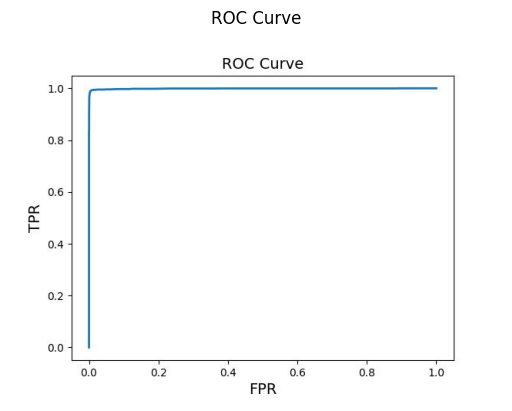

0.09126612
2.593165

Confusion Matrix:
 [[2974   14]
 [  30 2969]]

Classification Report:
               precision    recall  f1-score   support

   Different       0.99      1.00      0.99      2988
        Same       1.00      0.99      0.99      2999

    accuracy                           0.99      5987
   macro avg       0.99      0.99      0.99      5987
weighted avg       0.99      0.99      0.99      5987



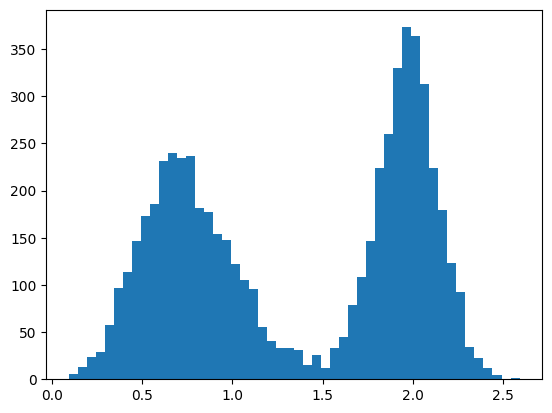

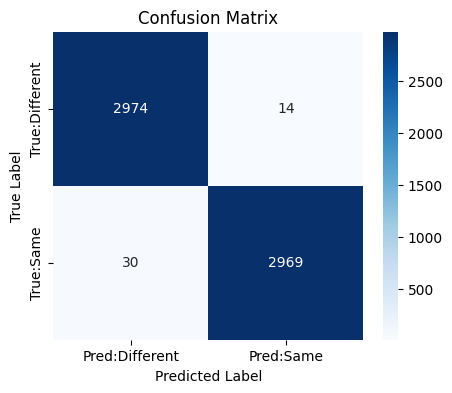

In [24]:
#############################
# 5) Main Evaluation Block
#############################

if __name__ == "__main__":
    # 1. Choose your device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 2. Path to your pretrained model
    pretrained_path = "/kaggle/working/resnet18_110.pth"
    # 3. Load the model (use_se=False, grayscale=True)
    face_model = load_pretrained_resnet18(pretrained_path, device)
    # 4. Path to your pairs file and data root
    pairs_file = "/kaggle/working/lfw_test_pair.txt"   # lines like: "Subdir/img1.jpg Subdir/img2.jpg 1.0"
    data_root = "/kaggle/working/align/lfw-align-128"
    # 5. Evaluate
    evaluate_face_model(face_model, pairs_file, data_root, device, image_size=128, batch_size=64)